In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline

In [2]:
class Constants:
    """
    Physical Constants
    """
    R = 8.314472                   # J/mol.K
    T0K = 273.15                   # K
    
    def TK(TC):
        """
        Temperature Conversion from Celcius to Kelvin
        """
        return TC + Constants.T0K
    
    def TC(TK):
        """
        Temperature Conversion from Kelvin to Celcius
        """
        return TK - Constants.T0K

In [3]:
class Conditions:
    """
    Standard Conditions
    """
    p0 = 1.01325e5                 # Pa
    T0 = 0 + Constants.T0K         # K

In [4]:
class Water:
    """
    Water Physical/Chemical Description
    """
    M = 18.0153e-3                 # [Kg/mol]
    Tvap = 99.94 + Constants.T0K   # [K]
    cp = 1.826e3                   # [J/kg.K]
    Hv = 40.662e3                  # [J/mol]
    lv = Hv/M                      # [J/Kg]

In [5]:
class Air:
    """
    Dry Air Physical/Chemical Description
    """
    M = 28.6953e-3                 # [Kg/mol]
    cp = 1.006e3                   # [J/Kg.K]

In [6]:
class Mix:
    """
    Mix of Gas and Liquid
    All quantities are expressed in Standard Units System
    """
    
    C = Constants
    CSTP = Conditions
    gas = Air
    liquid = Water
    
    Mr = liquid.M/gas.M
    
    def psat(T):
        """
        Saturation Pressure p_sat(T) [Pa]
        as a Temperature T [K] function
        """
        return Mix.CSTP.p0*np.exp(-Mix.liquid.Hv/Mix.C.R*(1/T - 1/Mix.liquid.Tvap))
    
    def xpw(pw):
        """
        Vapour Mass Ratio x(p_w) [Kg Liquid/Kg Gas]
        as a function of Liquid Partial Pressure p_w [Pa] 
        """
        return Mix.Mr*pw/(Mix.CSTP.p0-pw)
    
    def xw(T, phi):
        """
        Vapour Mass Ratio x(p_w) [Kg Liquid/Kg Gas]
        as a function of Liquid Partial Pressure p_w [Pa] 
        """
        return Mix.pisow(T, phi=phi)
    
    def pwx(x):
        """
        Liquid Partial Pressure p_w(x) [Pa]
        as a function of Vapour Mass Ratio x [Kg Liquid/Kg Gas]
        """
        return Mix.CSTP.p0*x/(x + Mix.Mr)
    
    def pisow(T, phi=1.):
        """
        Isopleth: Iso Relative Humidity (phi) Curve w(T)=k [-]
        as a function of Temperature T [K]
        Relative Humidity is defined as the ratio of Liquid Partial Pressure p_w [Pa]
        and Saturation Pressure p_sat(T) [Pa]:  w = p_w/p_sat(T)
        """
        return phi*Mix.psat(T)
    
    def pisov(T, v):
        """
        Isopleth (Isochoric): Iso Specific Volume Curve v(T)=k [m^3 Mix/Kg Gas]
        as a function of Temperature T [K]
        """
        return Mix.CSTP.p0 - (Mix.C.R*T)/(Mix.gas.M*v)
    
    def pisoh(T, h):
        """
        Isopleth (Isenthalpic): Iso Specific Enthalpy Curve h(T)=k [J/Kg Gas]
        as a function of Temperature T [K]
        """
        dT = (T - Mix.CSTP.T0)
        return Mix.CSTP.p0*(h - Mix.gas.cp*dT)/\
                ((h + Mix.Mr*Mix.liquid.lv) + (Mix.Mr*Mix.liquid.cp - Mix.gas.cp)*dT)

    def Tmin_score(f, k):
        """
        Score function for then intersection of the k-isopleth of kind f and Saturation Curve p_sat(T)
        as a function of Temperature T [K]
        Score function is designed to determine Tmin [K] for Psychrometric Chart Display
        """
        def inner(T):
            return Mix.psat(T) - f(T, k)
        return inner
    
    def Tmin(f, k, tol=5e-3):
        """
        Solve score function to determine Tmin [K] for Psychrometric Chart Display
        """
        return optimize.root(Mix.Tmin_score(f, k), 0.1, tol=tol)
    
    def Tmax(f, k, tol=5e-3):
        """
        Find root of the k-isopleth of kind f to get Tmax [K] for Psychrometric Chart Display
        """
        return optimize.root(lambda T: f(T, k), 0.1, tol=tol)
    
    def Boundaries(f, konsts, Tmin, Tmax):
        """
        Compute Temperature Boundaries for a given isopleth of a kind f of level k
        """
        n = konsts.size
        Ts = np.full((n, 2), np.nan)
        for i, k in enumerate(konsts):
            rmin = Mix.Tmin(f, k)
            if rmin.success:
                Ts[i,0] = max(rmin.x[0], Tmin)
            rmax = Mix.Tmax(f, k)
            if rmax.success:
                Ts[i,1] = min(rmax.x[0], Tmax)
        return Ts
    
    def domestic_ranges():
        """
        Basic Ranges for Domestic Use
        """
        return {
            'Tmin': +0. + Constants.T0K,           # [K]
            'Tmax': +35. + Constants.T0K,           # [K]
            'isow': np.arange(0.1, 0.91, 0.1),      # [-]
            'isov': np.arange(0.76, 0.95, 0.01),    # [m^3/kg]
            'isoh': np.arange(-1.e4, 13.1e4, 1e4),  # [J/Kg]
            'kOy': 1000.,                           # [KJ/J]
            'ylim': [0., 5.e3],                     # [Pa]
            'Tmode': 'kelvin',
            'ymode': 'partial'
        }
    
    def compute(f, konsts, Tmin, Tmax, ns=101):
        """
        Compute k-isopleths of kind f for the given Temperature Range (Tmin, Tmax) [K]
        Temperature Range is refined to real Temperature Boundaries (keep resolution equals, nice display)
        """
        nk = konsts.size
        T = np.full((ns, nk), np.nan)
        xT = np.full((ns, nk), np.nan)
        Ts = Mix.Boundaries(f, konsts, Tmin, Tmax)
        for i, k in enumerate(konsts):
            T[:,i] = np.linspace(*Ts[i,:], ns)
            xT[:,i] = f(T[:,i], k)
        return T, xT
    
    _requiredKeys = ('Tmin', 'Tmax', 'isow', 'isov', 'isoh', 'ylim')
    
    def plot(Tmin=None, Tmax=None, ns=101, rtype='domestic',
             isow=None, isov=None, isoh=None,
             kOy=None, ylim=None, Tmode=None, ymode=None):
        """
        Plot Psychrometric Chart for the given Temperature Range (Tmin, Tmax) [K]
        Including k-isopleths of each kind (iso-w, iso-v, iso-h)
        Also perform Units Conversion for readability sake
        """
        
        # Parameters:
        ranges = getattr(Mix, '{}_ranges'.format(rtype))()
        Tmin = Tmin or ranges['Tmin']
        Tmax = Tmax or ranges['Tmax']
        isow = isoh or ranges['isow']
        isov = isoh or ranges['isov']
        isoh = isoh or ranges['isoh']
        ylim = ylim or ranges['ylim']
        kOy = kOy or ranges['kOy']
        Tmode = Tmode or ranges['Tmode']
        ymode = ymode or ranges['ymode']
        
        
        # Temperature:
        T = np.linspace(Tmin, Tmax, ns)
            
        # Curves:
        psat = Mix.psat(T)/kOy
        pphi = np.array([Mix.pisow(T, phi=phi)/kOy for phi in isow]).T
        Tv, pv = Mix.compute(Mix.pisov, isov, Tmin, Tmax, ns)
        Th, ph = Mix.compute(Mix.pisoh, isoh, Tmin, Tmax, ns)
        
        # Polygons:
        T1 = Constants.TK(np.linspace(15, 27, 10))
        X1 = np.concatenate((Mix.pisow(T1, phi=0.4), np.array([0., 0.])))/kOy
        T1 = np.concatenate((T1, Constants.TK(np.array([27, 15]))), axis=0)
        P1 = Polygon(np.array([T1, X1]).T, True)
        
        T2 = Constants.TK(np.linspace(15, 23, 10))
        X2 = np.concatenate((Mix.pisow(T2, phi=0.7), Mix.pisow(np.flip(T2), phi=1.)), axis=0)/kOy
        T2 = np.concatenate((T2, np.flip(T2)), axis=0)
        P2 = Polygon(np.array([T2, X2]).T, True)
        
        T3 = Constants.TK(np.linspace(23, 27, 10))
        X3 = np.concatenate((Mix.pisow(T3, phi=0.7), Mix.pisow(np.flip(T3), phi=1.)), axis=0)/kOy
        T3 = np.concatenate((T3, np.flip(T3)), axis=0)
        P3 = Polygon(np.array([T3, X3]).T, True)
        
        T4 = Constants.TK(np.array([17, 17, 26, 26]))
        X4 = Mix.pisow(T4, phi=np.array([0.45, 0.8, 0.5, 0.35]))/kOy
        P4 = Polygon(np.array([T4, X4]).T, True)
        
        # Figure:
        fig, axe = plt.subplots()
        l1 = axe.plot(T, psat, label=r"Saturation: $p_\mathrm{sat}(T)$", color='black', linewidth=2.0)
        l2 = axe.plot(T, pphi, color='black', linewidth=0.75)
        l3 = axe.plot(Tv, pv/kOy, color='blue', linewidth=0.75)
        l4 = axe.plot(Th, ph/kOy, color='violet', linewidth=0.75)
        axe.add_collection(PatchCollection([P1], color='blue', alpha=0.4))
        axe.add_collection(PatchCollection([P2], color='red', alpha=0.4))
        axe.add_collection(PatchCollection([P3], color='orange', alpha=0.4))
        axe.add_collection(PatchCollection([P4], color='green', alpha=0.4))
        
        axe.set_title(r"{} Psychrometric Chart: $p_0 = {:.3f}$ $[\mathrm{{kPa}}]$".format(
            Mix.liquid.__name__, Mix.CSTP.p0/kOy))
        axe.set_xlabel(r"Temperature, $T$ $[\mathrm{K}]$")
        axe.set_ylabel(r"Partial Pressure, $p_w$ $[\mathrm{kPa}]$")
        axe.legend(bbox_to_anchor=(1,1), loc='upper left', title='Isopleth Curves:')
        axe.set_xlim(T[[0,-1]])
        axe.set_ylim(np.array(ylim)/kOy)
        
        fig.text(0.75, 0, "© 2019 Jean Landercy" )
        
        axe.grid()
        return axe

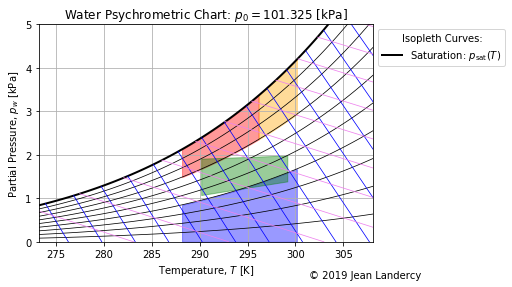

In [7]:
axe = Mix.plot()

In [8]:
df = pd.read_csv('Psychro_data.csv', header=[0,1], index_col=0, parse_dates=[0])
df.iloc[:6,:6]

channel             battery_status                                          \
device_name              node-T001 node-T002 node-T003 node-T004 node-T005   
timestamp                                                                    
2019-10-26 18:15:00            3.0       3.0       3.0       3.0       NaN   
2019-10-26 18:30:00            3.0       3.0       3.0       3.0       NaN   
2019-10-26 18:45:00            3.0       3.0       3.0       3.0       NaN   
2019-10-26 19:00:00            3.0       3.0       3.0       3.0       NaN   
2019-10-26 19:15:00            3.0       3.0       3.0       3.0       NaN   
2019-10-26 19:30:00            3.0       3.0       3.0       3.0       NaN   

channel             battery_voltage  
device_name               node-T001  
timestamp                            
2019-10-26 18:15:00        3.108000  
2019-10-26 18:30:00        3.106667  
2019-10-26 18:45:00        3.106000  
2019-10-26 19:00:00        3.106000  
2019-10-26 19:15:00        3.105333  
2019-10-26 19:30:00        3.104000

In [9]:
T = df['node_temperature'] + Constants.T0K
T.columns = pd.MultiIndex.from_product([['T'], T.columns])
T.head()

T                                            
                      node-T001   node-T002 node-T003   node-T004 node-T005
timestamp                                                                  
2019-10-26 18:15:00  291.265000  293.345000    293.20  294.885000       NaN
2019-10-26 18:30:00  291.226667  293.303333    293.16  294.863333       NaN
2019-10-26 18:45:00  291.203333  293.263333    293.13  294.840000       NaN
2019-10-26 19:00:00  291.290000  293.240000    293.10  294.813333       NaN
2019-10-26 19:15:00  291.206667  293.200000    293.07  294.786667       NaN

In [10]:
RH = df['node_humidity']/100.
RH.columns = pd.MultiIndex.from_product([['RH'], RH.columns])
RH.head()

RH                                        
                    node-T001 node-T002 node-T003 node-T004 node-T005
timestamp                                                            
2019-10-26 18:15:00  0.599500  0.741500  0.736500  0.691000       NaN
2019-10-26 18:30:00  0.601333  0.739333  0.734667  0.692000       NaN
2019-10-26 18:45:00  0.606667  0.739333  0.734000  0.691333       NaN
2019-10-26 19:00:00  0.607000  0.738333  0.733000  0.691333       NaN
2019-10-26 19:15:00  0.609000  0.736333  0.731667  0.692000       NaN

In [11]:
pw = pd.DataFrame(Mix.pisow(T.values , phi=RH.values)/1000., columns = T['T'].columns, index = T.index)
pw.columns = pd.MultiIndex.from_product([['pw'], pw.columns])
pw.head()

pw                                        
                    node-T001 node-T002 node-T003 node-T004 node-T005
timestamp                                                            
2019-10-26 18:15:00  1.528387  2.129416  2.097691  2.164907       NaN
2019-10-26 18:30:00  1.529676  2.118171  2.087712  2.165399       NaN
2019-10-26 18:45:00  1.541168  2.113359  2.082260  2.160476       NaN
2019-10-26 19:00:00  1.549739  2.107702  2.075875  2.157237       NaN
2019-10-26 19:15:00  1.547393  2.097216  2.068563  2.156079       NaN

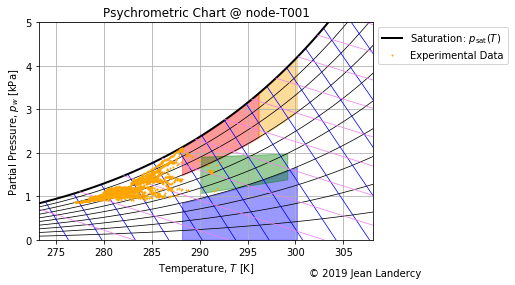

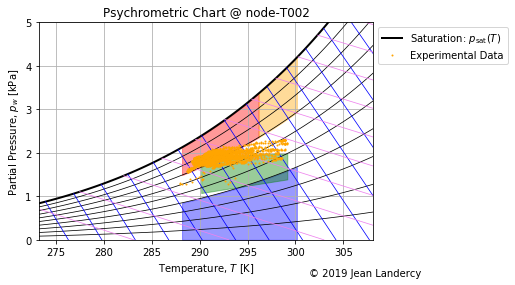

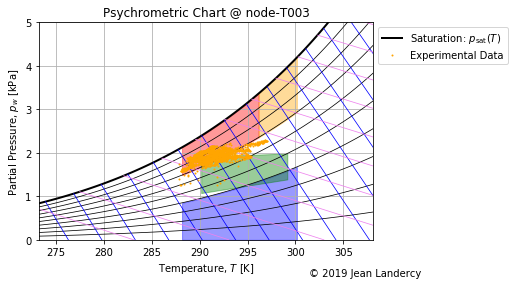

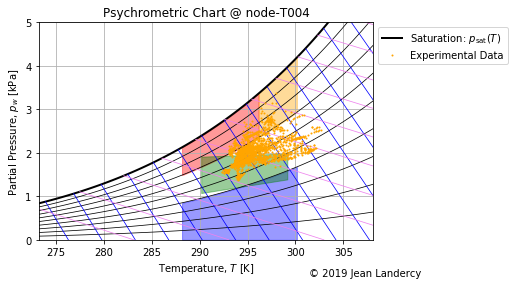

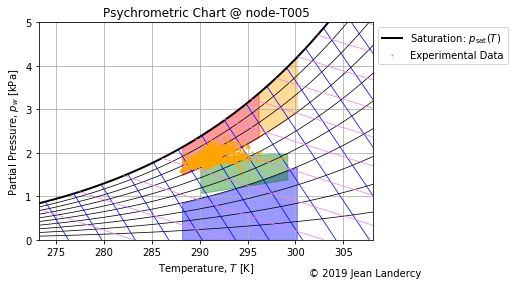

In [12]:
for k in T.columns.levels[-1]:
    idx = pd.IndexSlice[:,k]
    axe = Mix.plot()
    #axe.set_title(r"{} @ {}".format(axe.get_title(), k))
    axe.set_title(r"Psychrometric Chart @ {}".format(k))
    axe.plot(T.loc[:,idx].values.ravel(), pw.loc[:,idx].values.ravel(), '.',
             markersize=2, color='orange', label='Experimental Data')
    axe.legend(bbox_to_anchor=(1,1), loc='upper left')